In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import deque, Counter


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class TicTacToe:
    def __init__(self):
        """Инициализация среды."""
        self.board = np.zeros(9)  
        self.reset()

    def reset(self):
        """Сброс игры."""
        self.board = np.zeros(9)
        self.current_player = 1  
        self.done = False
        return self.board

    def step(self, action):
        if self._check_win() == -1:
            reward = -1
            self.done = True
            return self.board, reward, self.done
        if self.board[action] != 0:
            reward = -10  
            self.done = True
            return self.board, reward, self.done
        self.board[action] = self.current_player
        if self._check_win():
            reward = 1 
            self.done = True
        elif np.all(self.board != 0): 
            reward = 0.5
            self.done = True
        else:
            reward = -0.01  
            self.current_player *= -1

        return self.board, reward, self.done

    def _check_win(self):
        win_indices = [
            [0, 1, 2],
            [3, 4, 5],
            [6, 7, 8],
            [0, 3, 6], 
            [1, 4, 7], 
            [2, 5, 8], 
            [0, 4, 8], 
            [2, 4, 6],
        ]
        if np.any(self.board[combo] == self.current_player for combo in win_indices):
            return 1
        elif np.any(self.board[combo] == -self.current_player for combo in win_indices):
            return -1
        else:
            return False

In [3]:
class TicTacToeModel(nn.Module):
    def __init__(self):
        super(TicTacToeModel, self).__init__()
        self.fc1 = nn.Linear(9, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 9)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  
        return x

In [4]:
class DeepQAgent:
    def __init__(self, lr=0.01, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.model_x = TicTacToeModel().to(device)
        self.model_o = TicTacToeModel().to(device)
        self.target_model_x = TicTacToeModel().to(device)  
        self.target_model_x.load_state_dict(self.model_x.state_dict())
        self.target_model_o = TicTacToeModel().to(device)  
        self.target_model_o.load_state_dict(self.model_o.state_dict())
        self.target_model_x.eval()
        self.target_model_o.eval()
        self.action_size = 9
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.optimizer_x = optim.SGD(self.model_x.parameters(), lr=self.lr)
        self.optimizer_o = optim.SGD(self.model_o.parameters(), lr=self.lr)
        self.memory = deque(maxlen=10000) 
        
    def remember(self, state, action, reward, next_state, done, player):
        self.memory.append((state, action, reward, next_state, done, player))

    def act(self, state, player):
        model = self.model_x if player == 1 else self.model_o
        if np.random.rand() <= self.epsilon:
            return random.randint(0, self.action_size - 1)  
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = model(state).detach().cpu().numpy()
        return np.argmax(q_values)

    def apply_action(state, action, player):
        """
        Применяет действие игрока и возвращает новое состояние.
        """
        new_state = state.copy()
        new_state[action] = player  # Предполагается, что игроки обозначены как 1 (крестики) и -1 (нолики)
        return new_state
    
    def get_valid_actions(self, state):
        # Предполагаем, что 0 обозначает пустую клетку
        return [i for i, cell in enumerate(state) if cell == 0]
    
    def replay(self, batch_size):
        """Обучение на случайной выборке из памяти."""
        if len(self.memory) < batch_size:
            return
        
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done, player in batch:
            if player == 1:
                model = self.model_x
                target_model = self.target_model_x
                opponent_model = self.target_model_o
                optimizer = self.optimizer_x
            else:
                model = self.model_o
                target_model = self.target_model_o
                opponent_model = self.target_model_x
                optimizer = self.optimizer_o
            state = torch.tensor(state, dtype=torch.float32).to(device)
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
            target = model(state).detach().clone()
            if done:
                target[action] = reward
            else:
                # Ход противника с учётом маски
                valid_actions = self.get_valid_actions(next_state.cpu().numpy())
                opponent_q_values = opponent_model(next_state).detach().cpu().numpy()
                masked_opponent_q_values = np.full(opponent_q_values.shape, -np.inf)
                masked_opponent_q_values[valid_actions] = opponent_q_values[valid_actions]
                opponent_action = np.argmax(masked_opponent_q_values)

                # Применение действия противника
                next_next_state = self.apply_action(next_state.cpu().numpy(), opponent_action, -player)
                next_next_state = torch.tensor(next_next_state, dtype=torch.float32).to(device)
            
                # Q-значение после хода противника
                next_next_q_values = target_model(next_next_state).detach()
                target[action] = reward + self.gamma * torch.max(next_next_q_values)
                
            optimizer.zero_grad()
            output = model(state)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def update_target_model(self):
        """Копирование весов основной сети в модель-цель."""
        self.target_model_x.load_state_dict(self.model_x.state_dict())
        self.target_model_o.load_state_dict(self.model_o.state_dict())


In [5]:
eps = [1, 100, 500, 1000, 5000, 10000]

for episodes in eps:
    print(f"Started for {episodes}")
    env = TicTacToe()
    agent = DeepQAgent()


    #episodes = 5000
    batch_size = 32
    target_update_interval = 10  


    for episode in range(episodes):
        
        state = env.reset()
        total_reward = 0

        while True:
            # Агент 1
            action = agent.act(state, 1)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done, 1)
            # Агент -1
            action = agent.act(next_state, -1)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done, -1)
            state = next_state
            total_reward += reward
            if done:
                break

        # Обучение агента на накопленном опыте
        agent.replay(batch_size)

        # Обновление модели-цели
        if episode % target_update_interval == 0:
            agent.update_target_model()

        # Логируем прогресс
        #print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")
    model_x = agent.model_x
    model_o = agent.model_o
    torch.save(model_x, f"models\\model_x_{episodes}.pth")
    torch.save(model_o, f"models\\model_o_{episodes}.pth")


Started for 1
Started for 100
Started for 500
Started for 1000
Started for 5000
Started for 10000


In [6]:
class TicTacToe:
    def __init__(self):
        self.board = np.zeros(9, dtype=int)
        self.verbose = True

    def _display_board(self):
        if not self.verbose:
            return
        symbols = {0: ".", 1: "X", -1: "O"}
        for i in range(0, 9, 3):
            print(" ".join(symbols[self.board[j]] for j in range(i, i + 3)))
        print()
        
    def _reset_game(self):
        self.board = np.zeros(9, dtype=int)
        
    def _check_winner(self):
        winning_positions = [
            [0, 1, 2],  # Top row
            [3, 4, 5],  # Middle row
            [6, 7, 8],  # Bottom row
            [0, 3, 6],  # Left column
            [1, 4, 7],  # Middle column
            [2, 5, 8],  # Right column
            [0, 4, 8],  # Main diagonal
            [2, 4, 6]   # Anti-diagonal
        ]

        for player in [1, -1]:
            if any(all(self.board[pos] == player for pos in line) for line in winning_positions):
                return player

        if np.all(self.board != 0):  # No empty cells, draw
            return 0

        return None

    def play(self, player_x, player_o, verbose=False):
        self._reset_game()
        self.verbose = verbose
        current_player = 1
        players = {1: player_x, -1: player_o}
        self._display_board()

        while True:
            move = players[current_player].make_move(self.board.copy(), current_player)
            if self.board[move] != 0:
                raise ValueError(f"Invalid move at position {move}. Cell already taken.")
            self.board[move] = current_player

            self._display_board()
            winner = self._check_winner()
            if winner is not None:
                return winner
            current_player *= -1


class RandomPlayer:
    def make_move(self, board, player):
        available_moves = list(zip(*np.where(board == 0)))
        return random.choice(available_moves)


class DeepPlayer:
    def __init__(self, model_path_x=None, model_path_o=None):
        self.models = {
            -1: self.load_model(model_path_x) if model_path_x else None,
            1: self.load_model(model_path_o) if model_path_o else None
        }

    def load_model(self, path):
        model = torch.load(path).to(device)
        model.eval()
        return model

    def make_move(self, board, player):
        model = self.models[player]
        if model is None:
            raise ValueError(f"Модель для игрока {player} не загружена.")
        
        board_tensor = torch.tensor(board, dtype=torch.float32).to(device)
        with torch.no_grad():
            move_probs = model(board_tensor).cpu().numpy()
        
        available_moves = np.where(board == 0)[0]
        best_move = max(available_moves, key=lambda x: move_probs[x])
        return best_move


In [11]:
model_path_x = r'.\models\model_x_10000.pth'
model_path_o = r'.\models\model_o_10000.pth'
player1 = DeepPlayer(model_path_x=model_path_x, model_path_o=model_path_o)
player2 = RandomPlayer()
game = TicTacToe()

history = []

for _ in range(1000):
    history.append(game.play(player_x=player2, player_o=player1, verbose=True))  

history = Counter(history)

winner = history.keys()
numbers = history.values()

C:\Users\Ilya\AppData\Local\Temp\ipykernel_22444\1250909984.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path).to(device)


. . .
. . .
. . .

. . X
. . .
. . .

. . X
. . .
. . O

. . X
X . .
. . O

. . X
X . O
. . O

. X X
X . O
. . O

. X X
X . O
O . O

. X X
X X O
O . O

. X X
X X O
O O O

. . .
. . .
. . .

. . .
X . .
. . .

. . .
X . .
. . O

X . .
X . .
. . O

X . .
X . O
. . O

X . .
X . O
X . O

. . .
. . .
. . .

. . .
X . .
. . .

. . .
X . .
. . O

. . .
X X .
. . O

. . .
X X O
. . O

. X .
X X O
. . O

. X .
X X O
O . O

. X X
X X O
O . O

. X X
X X O
O O O

. . .
. . .
. . .

. . .
X . .
. . .

. . .
X . .
. . O

. . .
X . .
. X O

. . .
X . O
. X O

X . .
X . O
. X O

X . .
X . O
O X O

X . X
X . O
O X O

X O X
X . O
O X O

X O X
X X O
O X O

. . .
. . .
. . .

. X .
. . .
. . .

. X .
. . .
. . O

. X .
. . X
. . O

. X .
. O X
. . O

. X .
. O X
. X O

. X .
. O X
O X O

X X .
. O X
O X O

X X .
O O X
O X O

X X X
O O X
O X O

. . .
. . .
. . .

. . .
. . .
. X .

. . .
. . .
. X O

X . .
. . .
. X O

X . .
. . O
. X O

X . .
. . O
X X O

X O .
. . O
X X O

X O X
. . O
X X O

X O X
. O O


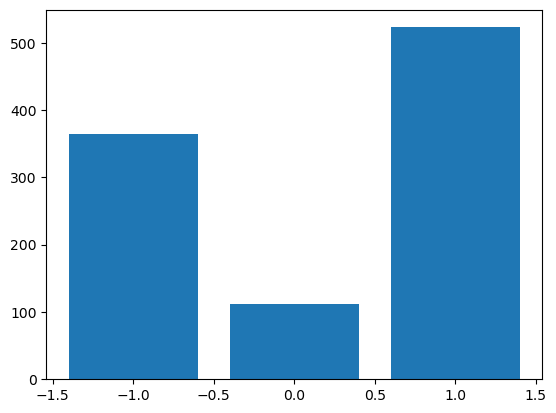

In [12]:
import matplotlib.pyplot as plt 
plt.bar(winner, numbers)
plt.show()